<a href="https://colab.research.google.com/github/jadinsstewart/Congressional-Analytics/blob/main/Project_1_Part_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Analysis Comparing Political Affiliation and Household Internet Access </center></h1>

Ella Archie (earchie@calpoly.edu)

Jadin Stewart (jsstewar@calpoly.edu)

February 5th, 2023

# Introduction

Last week, we presented our analysis comparing district political affiliation and the percentage of households owning at least one computer in that district. While we found evidence to support our hypothesis that districts with a high percentage of households having 1+ computers tend to be democratic, we were left with a few questions we wanted to further investigate.

To further our investigation, we will narrow in on households who own a computer. We will compare the % of households per district with a computer and broadband internet access and the % of households per district with a computer but no internet access to political affiliation.

# About

For our analysis we utilized data from the following sources: 

Party affiliation of each congressional district: https://www.house.gov/representatives (in csv format: http://goodcsv.com/politics/us-house-of-representatives-2020/ )  


American Community Survey 2021 dataset available from census.gov. The data is available via API from here: https://www.census.gov/data/developers/data-sets/acs-1year.html and the 2021 variable information can be found here:
https://api.census.gov/data/2021/acs/acs1/variables.html

Census term definitions: https://www2.census.gov/programs-surveys/acs/tech_docs/subject_definitions/2020_ACSSubjectDefinitions.pdf


For the purpose of our analysis, we've removed the libertarian district given the low sample size (n=1)

# Hypothesis

Based on our prior findings that access to a computer within the household corresponds to more democratic leaning districts, we predict that districts with high percentages of households that have a computer but no internet access are more likely to be republican, while districts with higher percentages of households with internet access at home will tend to be democratic. 

# ACS Data

In [14]:
# Libraries
import pandas as pd  
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [2]:
# URL for ACS Computer Data
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B28003_004E,B28003_005E&for=congressional%20district:*&in=state:*"

# Storing the Response of the URL
response = urlopen(url)

# Storing JSON Response from URL in Data
data_json = json.loads(response.read()) 

# Removing the First Row (Headers)
data_json.pop(0)

# Manually Populating Columns
cols = ['District Name','Total Households','Computer with Broadband Internet', 'Computer with No Internet', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# Cleaning the Data
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True) 
acs_df['district number'] = pd.to_numeric(acs_df['district number'])
acs_df['State'] = acs_df['State'].str.strip()

# Keeping Only Our Selected Columns
acs_df = acs_df[['Total Households', 'Computer with Broadband Internet', "Computer with No Internet", 'district number', 'State']]

# Looking at the Top Results
acs_df.head()

,Total Households,Computer with Broadband Internet,Computer with No Internet,district number,State
0,287768,239824,24786,1,Alabama
1,267988,220902,25098,2,Alabama
2,285773,239847,24411,3,Alabama
3,265042,213249,26308,4,Alabama
4,312227,270312,20398,5,Alabama


In [3]:
# Convert Columns to Numeric Data Types
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Computer with Broadband Internet"] = pd.to_numeric(acs_df["Computer with Broadband Internet"])
acs_df['Computer with No Internet'] = pd.to_numeric(acs_df['Computer with No Internet'])

# Computing New Columns for Percentage of Households
acs_df['% of households with a Computer and Broadband Internet'] = (100*acs_df['Computer with Broadband Internet'])/acs_df['Total Households']
acs_df['% of households with a Computer but No Internet'] = (100*acs_df['Computer with No Internet'])/acs_df['Total Households']

# Looking at the Top Results
acs_df.head()

,Total Households,Computer with Broadband Internet,Computer with No Internet,district number,State,% of households with a Computer and Broadband Internet,% of households with a Computer but No Internet
0,287768,239824,24786,1,Alabama,83.339357,8.613188
1,267988,220902,25098,2,Alabama,82.429810,9.365345
2,285773,239847,24411,3,Alabama,83.929203,8.542095
3,265042,213249,26308,4,Alabama,80.458569,9.925974
4,312227,270312,20398,5,Alabama,86.575472,6.533067


# Political Affiliation Data

In [4]:
# Reading Congressional Data into Pandas Dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# Extracting District Number
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Keeping Our Selected Columns
party_df = party_df[['State', 'Party', "district number"]]

# Looking at the Top Results
party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


# Merging the Data

In [5]:
# Merging our Data
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [6]:
# Checking Party Breakdown
merged_df['Party'].value_counts()


D    233
R    201
L      1
Name: Party, dtype: int64

In [7]:
# Dropping Libertarian from the dataset 
merged_df.drop(merged_df[merged_df['Party'] == 'L'].index, inplace = True)
merged_df['Party'].value_counts()

D    233
R    201
Name: Party, dtype: int64

# Visualization

## Boxplot of % of households with a Computer and Broadband Internet

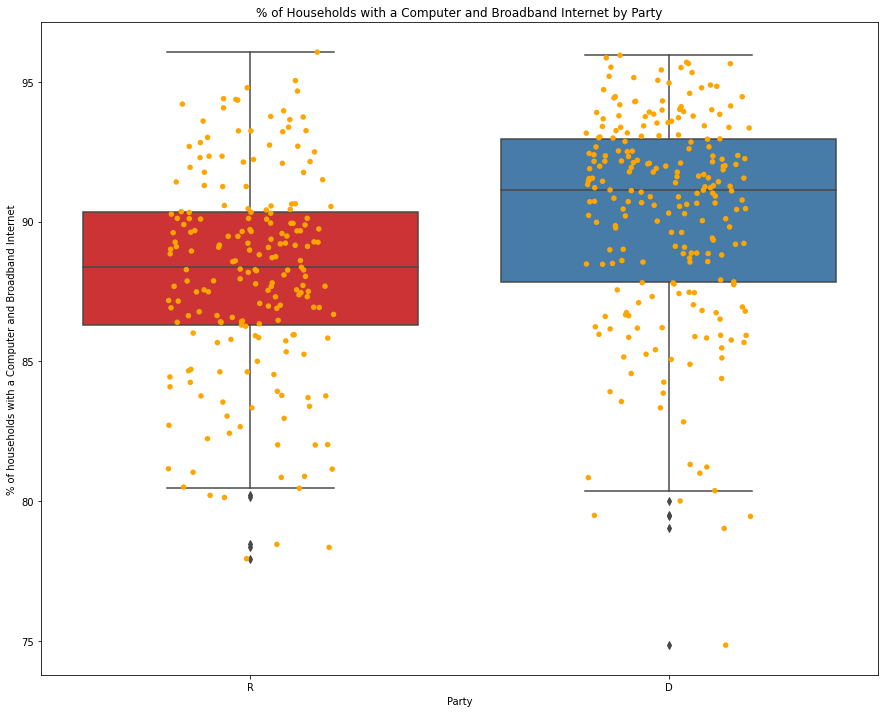

In [8]:
fig, ax = plt.subplots(figsize=(15, 12))

ax = sns.boxplot(x='Party', y='% of households with a Computer and Broadband Internet', data = merged_df, ax=ax, palette="Set1")

ax = sns.stripplot(x='Party', y='% of households with a Computer and Broadband Internet', data=merged_df, color="orange", jitter=0.2, size=5.5, ax=ax)

plt.title("% of Households with a Computer and Broadband Internet by Party")

# show the graph
plt.show()

In [9]:
merged_df.groupby(["Party"])["% of households with a Computer and Broadband Internet"].describe()

,count,mean,std,min,25%,50%,75%,max
Party,,,,,,,,
D,233.0,90.235007,3.746009,74.846394,87.847733,91.124827,92.964184,95.954320
R,201.0,88.146945,3.639849,77.941603,86.300428,88.368752,90.331071,96.067298


## Histograms of Distribution of % of Households with a Computer and Broadband Internet by Party

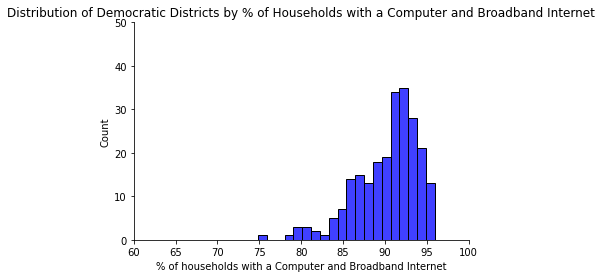

In [10]:
df_dem = merged_df[merged_df['Party']== "D"]

sns.histplot(df_dem["% of households with a Computer and Broadband Internet"], bins = 20, color="blue").set(title="Distribution of Democratic Districts by % of Households with a Computer and Broadband Internet")

plt.xlim(60, 100)

plt.ylim(0, 50)

sns.despine()

This distribution is skewed left. The median % of households with a computer and broadband internet access appears to be about 90%.

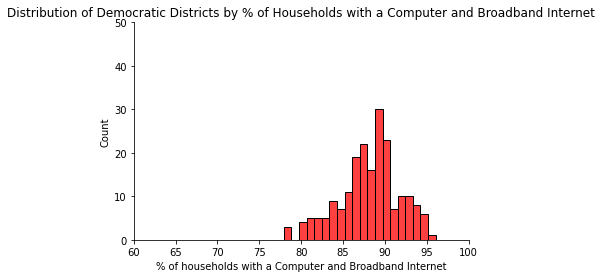

In [11]:
df_dem = merged_df[merged_df['Party']== "R"]

sns.histplot(df_dem["% of households with a Computer and Broadband Internet"], bins = 20, color="red").set(title="Distribution of Democratic Districts by % of Households with a Computer and Broadband Internet")

plt.xlim(60, 100)

plt.ylim(0, 50)

sns.despine()

This distribution looks relatively normal. The median % of households with a computer and broadband internet access appears to be about 87%.

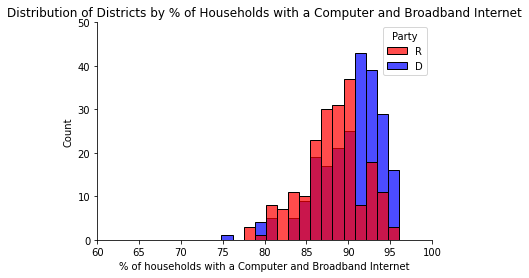

In [12]:
# democrat and republican graphs on same plot 

sns.histplot(data = merged_df, x = "% of households with a Computer and Broadband Internet", alpha = .7, hue = 'Party',palette=dict(R = "red", D= "blue")).set(title="Distribution of Districts by % of Households with a Computer and Broadband Internet")

plt.xlim(60, 100)

plt.ylim(0, 50)

sns.despine()


## Histograms of Distribution of % of Households with a Computer but No Internet Access by Party

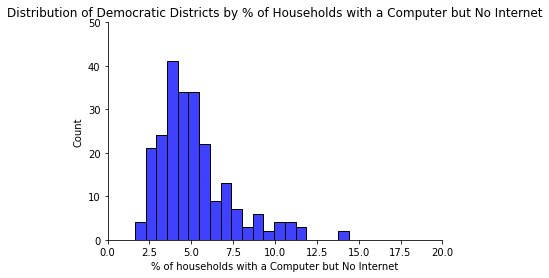

In [ ]:
df_dem = merged_df[merged_df['Party']== "D"]

sns.histplot(df_dem["% of households with a Computer but No Internet"], bins = 20, color="blue").set(title="Distribution of Democratic Districts by % of Households with a Computer but No Internet")

plt.xlim(0, 20)

plt.ylim(0, 50)

sns.despine()


This distribution is skewed right. The median % of households with a computer but no internet access appears to be about 4.5%.

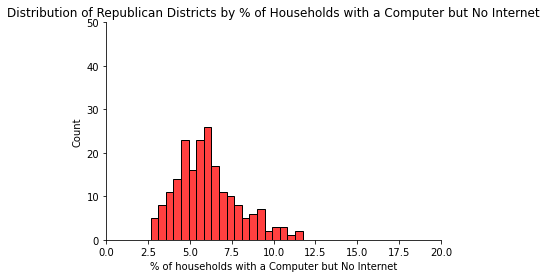

In [ ]:
df_dem = merged_df[merged_df['Party']== "R"]

sns.histplot(df_dem["% of households with a Computer but No Internet"], bins = 20, color="red").set(title="Distribution of Republican Districts by % of Households with a Computer but No Internet")

plt.xlim(0, 20)

plt.ylim(0, 50)

sns.despine()

This distribution is relatively normal. The median % of households with a computer but no internet access appears to be about 6%.

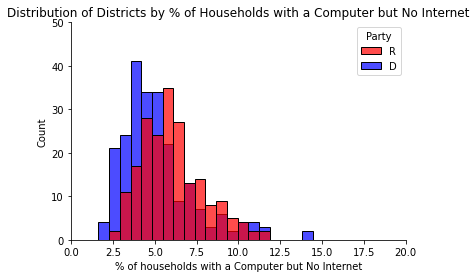

In [ ]:
# democrat and republican graphs on same plot 


sns.histplot(data = merged_df, x = "% of households with a Computer but No Internet", alpha = .7, hue = 'Party', palette=dict(R = "red", D= "blue")).set(title="Distribution of Districts by % of Households with a Computer but No Internet")

plt.xlim(0, 20)

plt.ylim(0, 50)


sns.despine()


In [ ]:
df_descending = merged_df.sort_values("% of households with a Computer but No Internet",ascending=False)

desc = df_descending[["Party","% of households with a Computer but No Internet", "State"]]

# top 10 
print(desc.head(10))

    Party  % of households with a Computer but No Internet        State
110     D                                        14.429441      Florida
221     D                                        13.880445  Mississippi
256     D                                        11.748387   New Mexico
315     R                                        11.737833     Oklahoma
20      R                                        11.536418     Arkansas
255     D                                        11.529667   New Mexico
369     D                                        11.487711        Texas
176     R                                        11.173033    Louisiana
6       D                                        10.984436      Alabama
36      D                                        10.927176   California


We can see that the first outlier lies in district 110 in Florida. This district is in Miami-Dade county. The median age in this distirct is around 55 years old. Only 55% of the district is employed which could explain why a large portion of the county doesn't need internet access.

In [ ]:
df_ascending = merged_df.sort_values("% of households with a Computer but No Internet",ascending=True)

asc = df_ascending[["Party","% of households with a Computer but No Internet", "State"]]

# bottom 10 
print(asc.head(10))

    Party  % of households with a Computer but No Internet          State
72      D                                         1.636118     California
246     D                                         1.807572     New Jersey
412     D                                         2.182429       Virginia
248     D                                         2.188039     New Jersey
38      D                                         2.456496     California
65      D                                         2.480208     California
259     D                                         2.482975       New York
50      D                                         2.499308     California
68      D                                         2.552644     California
193     D                                         2.569987  Massachusetts


The first outlier lies in district 72 in California. This district lies in between Hungtington Beach and Long Beach in Orange county. The median age in this district is around 40 which is much lower than in Florida's 110th district. This area has a high median household income and a high percentage of households enrolled in undergraudate or graduate degrees which could contribute to the low percentage of households with a computer but no internet.

# Statistical Analysis


Null: The median percentage of democratic households with a computer and internet access per district is equal to the median percentage of republican households with a computer and internet access per district.

Alternative: The median percentage of democratic households with a computer and internet access per district is not equal to the median percentage of republican households with a computer and internet access per district.

In [21]:
# Creating data groups

df_dem = merged_df[merged_df['Party']== "D"]
data_group1 = df_dem["% of households with a Computer and Broadband Internet"]
 
df_rep = merged_df[merged_df['Party']== "R"]
data_group2 = df_rep["% of households with a Computer and Broadband Internet"]
 

# Perform the two sample t-test with equal variances
stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)

Ttest_indResult(statistic=5.866739948608427, pvalue=8.852586870925128e-09)

Test Statistic: 5.866739948608427

P-Value: 8.852586870925128e-09

Conclusion: Reject the null hypothesis. The median percentage of democratic households with a computer and internet access per district is not equal to the median percentage of republican households with a computer and internet access per district.



# Findings

Our findings supported our first hypothesis and slightly contradicted our second. First, we can see in the boxplot that districts with a higher percentage of households owning a computer with broadband internet access tend to be democratic. Districts with a lower percentage of households owning a computer with broadband internet access tend to be republican. In addition, our statistical analysis concluded that the median percentage of households with a computer and internet access is not the same across political parties. This supported our original hypothesis.

Second, from the histograms we can see that the median percentage of households with a computer but no internet looks to be about 6% for Republican districts and 4.5% for Democratic districts. Even though the median is higher for Republicans, there are a greater number of Democratic regions with 4-6% of households having a computer but not internet. Moving forward, we would want to further investigate how income plays a role in this. 

Based on the original study which looked at political affiliation with incomes greater than 200k, and less than 10k, these results make sense. Democratic districts were more spread out with more districts in both the highest and lowest income brackets compared to republican districts. This makes sense with our data because democratic districts had both the highest and lowest percentages of internet access. This leads us to believe that income and internet access are likely to be correlated as well. 